# Implemntation of Seq2Seq with Bahdanau attention

(Reference: [Neural Machine Translation by Jointly Learning to Align and Translate by Dzmitry Bahdanau et al (2015)](https://arxiv.org/abs/1409.0473))

A few things to note:

* For brevity, I fixed all inputs at a max_length.
* Because of my low computing power, I changed a dataset from machine translation to character ordering.
* I tried not using high level Tensorflow RNN API to clearly show how the method works.

In [161]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datahelper

## Hyperparameters

In [180]:
epoch = 5
batch_size = 80
max_length = 30
X_vocab_size = len(vocab_to_int)
y_vocab_size = len(vocab_to_int)
embed_size = 20
rnn_hidden_unit = 50
align_hidden_unit = rnn_hidden_unit
maxout_hidden_unit = rnn_hidden_unit // 2

## Data Generation

In [181]:
alphabets = 'pwjlvcqrxhgiouymnfadztebsk' # Shuffled

vocab_to_int = {c: i+1 for i, c in enumerate(list(alphabets))}
START_TOKEN = 0
vocab_to_int['<s>'] = START_TOKEN
int_to_vocab = {i: c for c, i in vocab_to_int.items()}

X_train_chars, y_train_chars = datahelper.get_random_chars(160000, length=max_length)
X_test_chars, y_test_chars = datahelper.get_random_chars(16000, length=max_length)

X_train = [[vocab_to_int[c] for c in list(chars)] for chars in X_train_chars]
y_train = [[vocab_to_int[c] for c in list(chars)] for chars in y_train_chars]
X_test = [[vocab_to_int[c] for c in list(chars)] for chars in X_test_chars]
y_test = [[vocab_to_int[c] for c in list(chars)] for chars in y_test_chars]

## Graph Creation

### Reset Graph

In [182]:
tf.reset_default_graph()

### Initializers

In [183]:
orthogonal_init = tf.orthogonal_initializer()
normal_dense_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.001)
normal_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.01)
zero_init = tf.zeros_initializer()

### Input & Target Placeholders

In [184]:
X = [tf.placeholder(tf.int32, (batch_size,), "X_{}".format(i)) for i in range(max_length)]
y = [tf.placeholder(tf.int32, (batch_size,), "y_{}".format(i)) for i in range(max_length)]
is_inference = tf.placeholder(tf.bool, name="is_inference")

### Encoder Embedding

In [185]:
X_embed = tf.get_variable("X_embed", [X_vocab_size, embed_size])

### Encoder Parameters

In [186]:
# Forward
W_forward = tf.get_variable("W_forward", 
                            [embed_size, rnn_hidden_unit], 
                            initializer=normal_init)
W_forward_z = tf.get_variable("W_forward_z", 
                              [embed_size, rnn_hidden_unit], 
                              initializer=normal_init)
W_forward_r = tf.get_variable("W_forward_r", 
                              [embed_size, rnn_hidden_unit], 
                              initializer=normal_init)

U_forward = tf.get_variable("U_forward", 
                            [rnn_hidden_unit, rnn_hidden_unit], 
                            initializer=orthogonal_init)
U_forward_z = tf.get_variable("U_forward_z", 
                              [rnn_hidden_unit, rnn_hidden_unit], 
                              initializer=orthogonal_init)
U_forward_r = tf.get_variable("U_forward_r", 
                              [rnn_hidden_unit, rnn_hidden_unit], 
                              initializer=orthogonal_init)

b_forward_h = tf.get_variable("b_forward_h", shape=(rnn_hidden_unit,), initializer=zero_init)
b_forward_z = tf.get_variable("b_forward_z", shape=(rnn_hidden_unit,), initializer=zero_init)
b_forward_r = tf.get_variable("b_forward_r", shape=(rnn_hidden_unit,), initializer=zero_init)

# Backward
W_backward = tf.get_variable("W_backward", 
                             [embed_size, rnn_hidden_unit], 
                             initializer=normal_init)
W_backward_z = tf.get_variable("W_backward_z", 
                               [embed_size, rnn_hidden_unit], 
                               initializer=normal_init)
W_backward_r = tf.get_variable("W_backward_r", 
                               [embed_size, rnn_hidden_unit], 
                               initializer=normal_init)

U_backward = tf.get_variable("U_backward", 
                             [rnn_hidden_unit, rnn_hidden_unit],
                             initializer=orthogonal_init)
U_backward_z = tf.get_variable("U_backward_z",
                               [rnn_hidden_unit, rnn_hidden_unit],
                               initializer=orthogonal_init)
U_backward_r = tf.get_variable("U_backward_r",
                               [rnn_hidden_unit, rnn_hidden_unit],
                               initializer=orthogonal_init)

b_backward_h = tf.get_variable("b_backward_h", shape=(rnn_hidden_unit,), initializer=zero_init)
b_backward_z = tf.get_variable("b_backward_z", shape=(rnn_hidden_unit,), initializer=zero_init)
b_backward_r = tf.get_variable("b_backward_r", shape=(rnn_hidden_unit,), initializer=zero_init)

### Encoder Forward

In [187]:
h_forward = []
h_forward_init = tf.zeros([batch_size, rnn_hidden_unit], name="h_forward_init")

for i, x_i in enumerate(X):
    Ex_i = tf.nn.embedding_lookup(X_embed, x_i)
    h_i_prev = h_forward[i-1] if i > 0 else h_forward_init
    z_i = tf.sigmoid(tf.matmul(Ex_i, W_forward_z) +
                     tf.matmul(h_i_prev, U_forward_z) + 
                     b_forward_z)
    r_i = tf.sigmoid(tf.matmul(Ex_i, W_forward_r) +
                     tf.matmul(h_i_prev, U_forward_r) +
                     b_forward_r)
    h__i = tf.tanh(tf.matmul(Ex_i, W_forward) +
                   tf.matmul(tf.multiply(r_i, h_i_prev), U_forward) +
                   b_forward_h)
    h_i = tf.add(tf.multiply((1 - z_i), h_i_prev), 
                 tf.multiply(z_i, h__i), 
                 name="h_forward_{}".format(i))
    h_forward.append(h_i)

### Encoder Backward

In [188]:
h_backward = [None for i in range(len(X))]
h_backward_init = tf.zeros([batch_size, rnn_hidden_unit], name="h_backward_init")

for i, x_i in reversed(list(enumerate(X))):
    Ex_i = tf.nn.embedding_lookup(X_embed, x_i)
    h_i_prev = h_backward[i+1] if i < len(X)-1 else h_backward_init
    z_i = tf.sigmoid(tf.matmul(Ex_i, W_backward_z) + 
                     tf.matmul(h_i_prev, U_backward_z) + 
                     b_backward_z)
    r_i = tf.sigmoid(tf.matmul(Ex_i, W_backward_r) + 
                     tf.matmul(h_i_prev, U_backward_r) + 
                     b_backward_r)
    h__i = tf.tanh(tf.matmul(Ex_i, W_backward) + 
                   tf.matmul(tf.multiply(r_i, h_i_prev), U_backward) + 
                   b_backward_h)
    h_i = tf.add(tf.multiply((1 - z_i), h_i_prev), 
                 tf.multiply(z_i, h__i), 
                 name="h_backward_{}".format(i))
    h_backward[i] = h_i

### Annotations

In [189]:
h = [tf.concat([h_forward_i, h_backward_i], axis=1, name="h_{}".format(i)) 
     for i, (h_forward_i, h_backward_i) in enumerate(zip(h_forward, h_backward))]

### Decoder Embedding

In [190]:
y_embed = tf.get_variable('y_embed', [y_vocab_size, embed_size])

### Decoder RNN with GRU Parameters

In [191]:
W_dec = tf.get_variable("W_dec", [embed_size, rnn_hidden_unit], initializer=normal_init)
W_dec_z = tf.get_variable("W_dec_z", [embed_size, rnn_hidden_unit], initializer=normal_init)
W_dec_r = tf.get_variable("W_dec_r", [embed_size, rnn_hidden_unit], initializer=normal_init)

U_dec = tf.get_variable("U_dec", 
                        [rnn_hidden_unit, rnn_hidden_unit], 
                        initializer=orthogonal_init)
U_dec_z = tf.get_variable("U_dec_z", 
                          [rnn_hidden_unit, rnn_hidden_unit], 
                          initializer=orthogonal_init)
U_dec_r = tf.get_variable("U_dec_r", 
                          [rnn_hidden_unit, rnn_hidden_unit], 
                          initializer=orthogonal_init)

C_dec = tf.get_variable("C_dec", 
                        [rnn_hidden_unit*2, rnn_hidden_unit], 
                        initializer=normal_init)
C_dec_z = tf.get_variable("C_dec_z", 
                          [rnn_hidden_unit*2, rnn_hidden_unit], 
                          initializer=normal_init)
C_dec_r = tf.get_variable("C_dec_r", 
                          [rnn_hidden_unit*2, rnn_hidden_unit],
                          initializer=normal_init)

b_dec_s = tf.get_variable("b_dec_h", shape=(rnn_hidden_unit,), initializer=zero_init)
b_dec_z = tf.get_variable("b_dec_z", shape=(rnn_hidden_unit,), initializer=zero_init)
b_dec_r = tf.get_variable("b_dec_r", shape=(rnn_hidden_unit,), initializer=zero_init)

### Alignments Parameters

In [192]:
W_s = tf.get_variable("W_s", 
                      [rnn_hidden_unit, rnn_hidden_unit], 
                      initializer=normal_init)
b_s = tf.get_variable("b_s", 
                      shape=(rnn_hidden_unit,),
                      initializer=zero_init)

W_a = tf.get_variable("W_a", 
                      [rnn_hidden_unit, align_hidden_unit], 
                      initializer=normal_dense_init)
U_a = tf.get_variable("U_a", 
                      [rnn_hidden_unit*2, align_hidden_unit],
                      initializer=normal_dense_init)
b_a = tf.get_variable("b_a", 
                      shape=(align_hidden_unit,), 
                      initializer=zero_init)
v_a = tf.get_variable("v_a", 
                      [1, align_hidden_unit], 
                      initializer=zero_init)

### Output Parameters

In [193]:
W_o = tf.get_variable("W_o", [maxout_hidden_unit, y_vocab_size], initializer=normal_init)
b_wt = tf.get_variable("b_wt", (y_vocab_size,), initializer=zero_init)
U_o = tf.get_variable("U_o", [rnn_hidden_unit, maxout_hidden_unit*2], initializer=normal_init)
V_o = tf.get_variable("V_o", [embed_size, maxout_hidden_unit*2], initializer=normal_init)
C_o = tf.get_variable("C_o", [rnn_hidden_unit*2, maxout_hidden_unit*2], initializer=normal_init)
b_o = tf.get_variable("b_o", (rnn_hidden_unit,), initializer=zero_init)

### Decoder

In [194]:
s = []
s_init = tf.tanh(tf.matmul(h_backward[0], W_s), name="s_init")
y_init = tf.fill(y[0].shape, START_TOKEN, name="y_init")
y_preds = []
logits = []

for i, y_i in enumerate(y):
    # teacher forcing when training
    y_i_prev = tf.cond(is_inference, 
                       lambda: tf.cast(y_preds[i-1], tf.int32), 
                       lambda: tf.cast(y[i-1], tf.int32)) if i > 0 else y_init
    s_i_prev = s[i-1] if i > 0 else s_init
    
    # Creation of context vector
    e_i = []
    for j, h_j in enumerate(h):
        e_i_j = tf.matmul(
            tf.tanh(tf.matmul(s_i_prev, W_a) + tf.matmul(h_j, U_a) + b_a),
            tf.transpose(v_a),
            name="e_{}_{}".format(i, j))
        e_i.append(e_i_j)
    e_i_sum = tf.reduce_sum(tf.exp(e_i), axis=0)
    alpha_i = [tf.multiply(tf.exp(e_ij), 1/e_i_sum, name="alpha_{}_{}".format(i, j)) 
               for j, e_ij in enumerate(e_i)]
    weighted_c_i = [tf.multiply(alpha_i_j, h_j) for alpha_i_j, h_j in zip(alpha_i, h)]
    c_i = tf.reduce_sum(weighted_c_i, axis=0, name="c_{}".format(i))
    
    Ey_i_prev = tf.nn.embedding_lookup(y_embed, y_i_prev)
    z_i = tf.sigmoid(tf.matmul(Ey_i_prev, W_dec_z) + 
                    tf.matmul(s_i_prev, U_dec_z) +
                    tf.matmul(c_i, C_dec_z) +
                    b_dec_z)
    r_i = tf.sigmoid(tf.matmul(Ey_i_prev, W_dec_r) + 
                    tf.matmul(s_i_prev, U_dec_r) +
                    tf.matmul(c_i, C_dec_r) +
                    b_dec_r)
    s__i = tf.tanh(tf.matmul(Ey_i_prev, W_dec) +
                  tf.matmul(tf.multiply(r_i, s_i_prev), U_dec) +
                  tf.matmul(c_i, C_dec)+
                  b_dec_s)
    s_i = tf.add(tf.multiply(1-z_i, s_i_prev), tf.multiply(z_i, s__i), name="s_{}".format(i))
    s.append(s_i)
    
    t__i = tf.matmul(s_i_prev, U_o) + tf.matmul(Ey_i_prev, V_o) + tf.matmul(c_i, C_o) + b_o
    t_i = tf.contrib.layers.maxout(t__i, maxout_hidden_unit, axis=1, name="t_{}".format(i))
    logit = tf.add(tf.matmul(t_i, W_o), b_wt, name="logit_{}".format(i))
    logits.append(logit)
    y_pred = tf.argmax(tf.nn.softmax(logit), axis=1)
    y_preds.append(y_pred)

y_preds = tf.stack(y_preds, axis=1, name="y_preds")

### Optimization

In [195]:
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit)
          for logit, label in zip(logits, y)]
total_loss = tf.reduce_mean(losses)

optimizer = tf.train.AdadeltaOptimizer(learning_rate=1.0, rho=0.95, epsilon=10e-6)
gradients = optimizer.compute_gradients(total_loss)
clipped_grad = [(tf.clip_by_norm(grad, 1.), var) for grad, var in gradients if grad is not None]
train_op = optimizer.apply_gradients(clipped_grad)

### Session Helper Functions

In [196]:
def get_batches(X_train, y_train, batch_size):
    for i in range(0, len(X_train), batch_size):
        yield X_train[i:i+batch_size], y_train[i:i+batch_size]

def create_feed_dict(X_pls, y_pls, X_batch, y_batch):
    X_batch_array = np.array(X_batch)
    y_batch_array = np.array(y_batch)
    
    feed_dict = {}
    for i, (X_p, y_p) in enumerate(zip(X_pls, y_pls)):
        feed_dict[X_p] = X_batch_array[:, i]
        feed_dict[y_p] = y_batch_array[:, i]
    
    return feed_dict

def get_accuracy(predictions, targets):
    return np.sum(np.all(predictions == targets, axis=1)) / len(predictions)

### Session

In [197]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
init = tf.global_variables_initializer()

ckpt = './model.ckpt'
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(init)
    
    for e in range(epoch):
        for i, (X_batch, y_batch) in enumerate(get_batches(X_train, y_train, batch_size)):
            feed_dict = create_feed_dict(X, y, X_batch, y_batch)
            feed_dict[is_inference] = False
            predictions, cost, _ = sess.run([y_preds, total_loss, train_op], feed_dict=feed_dict)

            if i % 100 == 0:
                train_loss.append(cost)
                acc_val = get_accuracy(predictions, y_batch)
                train_acc.append(acc_val)
            if i % 1000 == 0:
                temp_test_loss = []
                temp_test_acc = []
                for X_test_batch, y_test_batch in get_batches(X_test, y_test, batch_size):
                    test_feed_dict = create_feed_dict(X, y, X_test_batch, y_test_batch)
                    test_feed_dict[is_inference] = False
                    test_predictions, test_cost = sess.run([y_preds, total_loss], 
                                                           feed_dict = test_feed_dict)
                    temp_test_loss.append(test_cost)
                    temp_test_acc_val = get_accuracy(test_predictions, y_test_batch)
                    temp_test_acc.append(temp_test_acc_val)
                test_loss.append(np.mean(temp_test_loss))
                test_acc.append(np.mean(temp_test_acc))
                
                print("Epoch: {} / Train Loss: {} / Test Loss: {}".format(e, cost, test_cost))
    
    saver.save(sess, ckpt)
    print("#### Model Saved! ####")

Epoch: 0 / Train Loss: 3.295853614807129 / Test Loss: 3.2951619625091553
Epoch: 0 / Train Loss: 1.1024222373962402 / Test Loss: 1.108607292175293
Epoch: 1 / Train Loss: 0.8943943381309509 / Test Loss: 0.8642669916152954
Epoch: 1 / Train Loss: 0.6416109800338745 / Test Loss: 0.6267961859703064
Epoch: 2 / Train Loss: 0.35798463225364685 / Test Loss: 0.3290613293647766
Epoch: 2 / Train Loss: 0.3765608072280884 / Test Loss: 0.3036957383155823
Epoch: 3 / Train Loss: 0.044456858187913895 / Test Loss: 0.04076521471142769
Epoch: 3 / Train Loss: 0.022236792370676994 / Test Loss: 0.020220382139086723
Epoch: 4 / Train Loss: 0.01481388695538044 / Test Loss: 0.013760560192167759
Epoch: 4 / Train Loss: 0.009242228232324123 / Test Loss: 0.009285565465688705
#### Model Saved! ####


## Plots

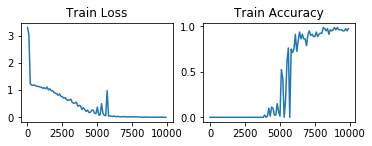

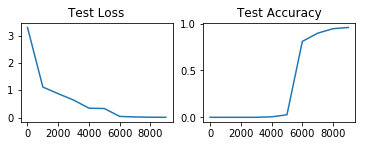

In [202]:
plt.figure(1)
plt.subplot(221)
plt.plot(np.arange(len(train_loss)) * 100, train_loss)
plt.title('Train Loss')

plt.subplot(222)
plt.plot(np.arange(len(train_acc)) * 100, train_acc)
plt.title('Train Accuracy')

plt.figure(2)
plt.subplot(221)
plt.plot(np.arange(len(test_loss)) * 1000, test_loss)
plt.title('Test Loss')

plt.subplot(222)
plt.plot(np.arange(len(test_acc)) * 1000, test_acc)
plt.title('Test Accuracy')

## Inference Function

In [199]:
def predict(text):
    text = text[:max_length]
    X_infer_batch = [[vocab_to_int[c] for c in list(text)] for i in range(batch_size)]
    y_infer_batch = np.zeros([batch_size, max_length]) # target is not necessary when inference

    infer_graph = tf.Graph()
    with tf.Session(graph=infer_graph) as sess:
        loader = tf.train.import_meta_graph(ckpt + '.meta')
        loader.restore(sess, ckpt)

        # Placeholder
        X_infer_pls = [infer_graph.get_tensor_by_name("X_{}:0".format(i)) 
                       for i in range(max_length)]
        y_infer_pls = [infer_graph.get_tensor_by_name("y_{}:0".format(i)) 
                       for i in range(max_length)]
        _is_inference = infer_graph.get_tensor_by_name("is_inference:0")

        infer_feed_dict = create_feed_dict(X_infer_pls, y_infer_pls, 
                                           X_infer_batch, y_infer_batch)
        infer_feed_dict[_is_inference] = True

        # Logit
        y_preds = infer_graph.get_tensor_by_name("y_preds:0")
        prediction = sess.run(y_preds, feed_dict=infer_feed_dict)
        
        return ''.join([int_to_vocab[n] for n in prediction[0]])

## Predict whatever you want

In [201]:
print(predict('qboieboqmgowheibowmebiwhgozibh')) # answer is "bbbbbeeegghhhiiiimmoooooqqwwwz"

INFO:tensorflow:Restoring parameters from ./model.ckpt
bbbbbeeegghhhiiiimmoooooqqwwwz
